# CAD PROJECT- Classical Approach
*By Jaime Simarro & Ahmed Gouda*

With this script you can find:
* Create and save the selected features using ANOVA
* Grid research of Candidate models using CV
* Candidate models selection using validation
* Creation of Ensemble model
* ROC curve
* Selection of optimal threshold

In [148]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [149]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import math
!pip install ciecam02
from ciecam02 import rgb2jch, jch2rgb
from skimage.feature import greycomatrix, greycoprops
from pandas import DataFrame
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif,f_classif
! pip install pymrmr
import pymrmr
from sklearn import svm, datasets, metrics
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier


In [0]:
#### JUST CHANGE THIS #####
dermo_challenge=True

if (dermo_challenge):
  window_tpe='Two'
  R_which_feat_calculate=[ 0,0, 1,  2,  4,4]
  R_which_color_calculate=[1,2, 3,  2,  2,3]

  R_which_feat_calculate_Windowing=[ 0,0, 1,  2]
  R_which_color_calculate_Windowing=[1,2, 3,  2]
  normalization_type=[]
else:
  window_tpe=''

  O_which_feat_calculate=[ 0  ,1,1,1,   2,2,  4,4,4]
  O_which_color_calculate=[1  ,0,1,3,   1,2,  1,2,3]

  O_which_feat_calculate_Windowing=[ 1,1,1,  4,4,4]
  O_which_color_calculate_Windowing=[0,1,3,  1,2,3]

  R_which_feat_calculate=[ 1, 2,  3,  4,4,4]
  R_which_color_calculate=[0, 2,  1,  0,1,3]

  R_which_feat_calculate_Windowing=[ 1,  4,4,4]
  R_which_color_calculate_Windowing=[0,  0,1,3]

###########################
switcher_feat = {
    0: "GLCM",
    1: "Histogram",
    2: "Fintesity",
    3: "Fstat",
    4: "Gabour",
    5: "Combination of features",
}

if (dermo_challenge):
  switcher_color_space = {
      0: "Frgb",
      1: "Fhsv",
      2: "Flab",
      3: "Fjch",  
      4: "Fhybrid",        
      5: "Fsix",
      6: "Combination of color spaces", 
  }
  normalization_type=''
else:
  switcher_color_space = {
      0: "Frgb",
      1: "Fhsv",
      2: "Flab",
      3: "Fjch",
      4: "Ftissue",    
      5: "Combination of color spaces", 

  }
  switcher_normalization = {
    0: "Original",
    1: "Reinhard",
    2: "Macenko",
  }


In [0]:
if (dermo_challenge):
  path_general_feat='/content/drive/My Drive/Colab Notebooks/CAD Project/Dermo Features/'
else:
  path_general_feat='/content/drive/My Drive/Colab Notebooks/CAD Project/Histopathology Features/'


## Load desired features

In [0]:
def create_names(name_X,color_space_type,feat_type):
  names=[]
  for n in range(name_X.shape[1]):
    names.append(color_space_type[1:]+'_'+feat_type+'_'+str(n))
  return names

def load_list_feat(path4load_folder_class,list_number_Feat,list_number_Color):
  if isinstance(list_number_Feat,int)  : # For int
    list_number_Feat=[list_number_Feat]
  if isinstance(list_number_Color,int)  : # For int
    list_number_Color=[list_number_Color]
  for f in range(len(list_number_Color)):
    feat_type=switcher_feat.get(list_number_Feat[f], "Invalid feature type")
    color_space_type=switcher_color_space.get(list_number_Color[f], "Invalid color space type")
    print("Adding feature ",feat_type,' ',color_space_type )
    path4load=path4load_folder_class+color_space_type+'_'+feat_type+'.npy'
    if(f==0):
      X = np.load(path4load, allow_pickle=True)
      name_feat=create_names(X,color_space_type,feat_type)
    else:
      new_X=np.load(path4load, allow_pickle=True)
      X=np.concatenate((X,new_X),axis=1)
      name_feat=name_feat+create_names(new_X,color_space_type,feat_type)
  return [X,name_feat]

def combine_window(normalization_type,bool_training):
  if(normalization_type=="Original"):
    which_feat_calculate=O_which_feat_calculate
    which_color_calculate=O_which_color_calculate
    which_feat_calculate_Windowing=O_which_feat_calculate_Windowing
    which_color_calculate_Windowing=O_which_color_calculate_Windowing
  else:
    which_feat_calculate=R_which_feat_calculate
    which_color_calculate=R_which_color_calculate
    which_feat_calculate_Windowing=R_which_feat_calculate_Windowing
    which_color_calculate_Windowing=R_which_color_calculate_Windowing
  # Global Features
  print("---Global features---")
  if (bool_training):
    path4load_global=path_general_feat+normalization_type+'/One/train/'
  else:
    path4load_global=path_general_feat+normalization_type+'/One/val/'
  [X_pos_global,names_feat_global]=load_list_feat(path4load_global+'pos/',which_feat_calculate,which_color_calculate)
  [X_neg_global,_]=load_list_feat(path4load_global+'neg/',which_feat_calculate,which_color_calculate)
  # Window Features
  if(window_tpe=='Two' or window_tpe=='Three'):
    print("---Window features---")
    if (bool_training):
      path4load_global=path_general_feat+normalization_type+'/'+window_tpe+'/train/'
    else:
      path4load_global=path_general_feat+normalization_type+'/'+window_tpe+'/val/'    
    [X_pos_window,names_feat_window]=load_list_feat(path4load_global+'pos/',which_feat_calculate_Windowing,which_color_calculate_Windowing)
    [X_neg_window,_]=load_list_feat(path4load_global+'neg/',which_feat_calculate_Windowing,which_color_calculate_Windowing)
    X_neg=np.concatenate((X_pos_global,X_pos_window),axis=1)
    X_pos=np.concatenate((X_neg_global,X_neg_window),axis=1)
    names=names_feat_global+ ["W_"+s  for s in names_feat_window]
  else:
    X_pos=X_pos_global
    X_neg=X_neg_global
    names=names_feat_global
  X=np.concatenate((X_pos,X_neg))
  y_pos=np.ones(X_pos.shape[0])
  y_neg=np.zeros(X_neg.shape[0])
  y=np.concatenate((y_pos,y_neg))
  return X,y,[normalization_type+"_"+s  for s in names]

In [0]:
def load_all_histo(bool_training):
  normalization_type=switcher_normalization.get(0, "Invalid normalization type")
  X_original,y,names_original=combine_window(normalization_type,bool_training)

  normalization_type=switcher_normalization.get(1, "Invalid normalization type")
  X_rein,_,names_rein=combine_window(normalization_type,bool_training)

  names=names_original+names_rein
  X=np.concatenate((X_original,X_rein),axis=1)
  rnd = np.random.RandomState(357)
  shuffled_indices = rnd.permutation(np.arange(y.shape[0]))
  X=X[shuffled_indices]
  y=y[shuffled_indices]
  return X,y,names

def load_all_dermo(bool_training):
  X,y,names=combine_window(normalization_type,bool_training)
  rnd = np.random.RandomState(357)
  shuffled_indices = rnd.permutation(np.arange(y.shape[0]))
  X=X[shuffled_indices]
  y=y[shuffled_indices]
  return X,y,names


In [168]:
if (dermo_challenge):
  print("****Starting training data****")
  X_train,y_train,names=load_all_dermo(bool_training=True)
  print("****Starting validation data****")
  X_val,y_val,_=load_all_dermo(bool_training=False)
else:
  print("****Starting training data****")
  X_train,y_train,names=load_all_histo(bool_training=True)
  print("****Starting validation data****")
  X_val,y_val,_=load_all_histo(bool_training=False)  

****Starting training data****
---Global features---
Adding feature  GLCM   Fhsv
Adding feature  GLCM   Flab
Adding feature  Histogram   Fjch
Adding feature  Fintesity   Flab
Adding feature  Gabour   Flab
Adding feature  Gabour   Fjch
Adding feature  GLCM   Fhsv
Adding feature  GLCM   Flab
Adding feature  Histogram   Fjch
Adding feature  Fintesity   Flab
Adding feature  Gabour   Flab
Adding feature  Gabour   Fjch
---Window features---
Adding feature  GLCM   Fhsv
Adding feature  GLCM   Flab
Adding feature  Histogram   Fjch
Adding feature  Fintesity   Flab
Adding feature  GLCM   Fhsv
Adding feature  GLCM   Flab
Adding feature  Histogram   Fjch
Adding feature  Fintesity   Flab
****Starting validation data****
---Global features---
Adding feature  GLCM   Fhsv
Adding feature  GLCM   Flab
Adding feature  Histogram   Fjch
Adding feature  Fintesity   Flab
Adding feature  Gabour   Flab
Adding feature  Gabour   Fjch
Adding feature  GLCM   Fhsv
Adding feature  GLCM   Flab
Adding feature  Histogra

In [0]:
index=np.unique(np.where(np.isnan(X_train))[0])
X_train=np.delete(X_train,index,0)
y_train=np.delete(y_train,index,0)

### Normalization

In [0]:
mean_X  = np.mean(X_train, 0)
std_X   = np.std(X_train,0)
X_train = (X_train-mean_X)/std_X
X_val = (X_val-mean_X)/std_X



## Feature Selection


In [0]:
def selection_mRMR(X,names,k):
  df = DataFrame(data=X[:1000,:],columns= names )
  selected=pymrmr.mRMR(df, 'MIQ',k)
  new_selection=[]
  for n in names:
    flag=False
    for s in selected:
      if(n==s):
        flag=True
    new_selection.append(flag)
  new_X=X[:,new_selection]
  return new_X

def select_and_save(X,y,names):
  values=[10,50,100,200,250]
  values=[300,340]

  for k in values:
    type_selector=f_classif
    selector=SelectKBest(type_selector, k=k)
    X_new = selector.fit_transform(X, y)
    mask = selector.get_support() #list of booleans
    all_names=[]
    for n in np.ndarray.tolist(np.nonzero(mask)[0]):
      all_names.append(names[n])
    np.save(path_general_feat+ 'W2_f_classif_'+str(k)+'.npy',all_names)
    if(window_tpe=='Two'):
        np.save(path_general_feat+ 'W2_f_classif_'+str(k)+'.npy',all_names)
    else:
      if(window_tpe=='Three'):
        np.save(path_general_feat+ 'W3_f_classif_'+str(k)+'.npy',all_names)
      else:
        np.save(path_general_feat+ 'f_classif_'+str(k)+'.npy',all_names)

def match_feat(X,selected,names):
  new_selection=[]
  for n in names:
    flag=False
    for s in selected:
      if(n==s):
        flag=True
    new_selection.append(flag)
  new_X=X[:,new_selection]
  return new_X



In [0]:
if(False):
  select_and_save(X_train,y_train,names)

## Grid research of Candidate models
Based on CV to select the best:
* Combination of features
* Number of feature


In [0]:
if(False):
  values=[10,50,100,200,250,300,340]
  for k in values:
    if(window_tpe=='Two'):
      selected=np.load(path_general_feat+ 'W2_f_classif_'+str(k)+'.npy')
    else:
      if(window_tpe=='Three'):
        selected=np.load(path_general_feat+ 'W3_f_classif_'+str(k)+'.npy')
      else:
        selected=np.load(path_general_feat+ 'f_classif_'+str(k)+'.npy')
    s_X_train=match_feat(X_train,selected,names)
    print("----------------------")
    print(s_X_train.shape)
    if(False):
      print("SVM ",window_tpe)
      clf = svm.SVC(gamma='scale', random_state=0)
    else:
      print("RF ",window_tpe)
      clf = RandomForestClassifier(n_estimators=1000,random_state=0)
    cv_results = cross_validate(clf, s_X_train, y_train, scoring = ['accuracy'],cv=3,return_train_score=True)

    test_accuracy=np.mean(cv_results['test_accuracy'])*100
    test_accuracy_std=np.std(cv_results['test_accuracy'])*2*1000

    s=str(round(test_accuracy,2)) + ' +/- ' + str(round(test_accuracy_std,2))
    print(k, ' ',s)

## Cadidate models selection

In [0]:
if(False):
  k=200
  bool_SVM=False
  window_tpe="Two"
  if(window_tpe=='Two'):
    selected=np.load(path_general_feat+ 'W2_f_classif_'+str(k)+'.npy')
  else:
    if(window_tpe=='Three'):
      selected=np.load(path_general_feat+ 'W3_f_classif_'+str(k)+'.npy')
    else:
      selected=np.load(path_general_feat+ 'f_classif_'+str(k)+'.npy')
  s_X_train=match_feat(X_train,selected,names)
  s_X_val=match_feat(X_val,selected,names)

  if(bool_SVM):
    clf = svm.SVC(gamma='scale', random_state=0,probability=True).fit(s_X_train, y_train) 
  else:
    clf = RandomForestClassifier(n_estimators=1000,random_state=0).fit(s_X_train, y_train)

  y_score=clf.predict_proba(s_X_val)[:, 1]
  print("Classification report for classifier %s:\n%s\n"
        % (clf, metrics.classification_report(y_val, y_score>0.5)))

Saving the model

In [0]:
from joblib import dump, load
#dump(clf, path_general_feat+'SVM_W2_200.joblib') 

## Ensemble & ROC

AUC  for RF  0.9030847222222221
(1200, 200)
AUC  for SVM  0.9009347222222222
AUC  for Ensemble  0.906325
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81       600
         1.0       0.78      0.91      0.84       600

    accuracy                           0.83      1200
   macro avg       0.84      0.83      0.83      1200
weighted avg       0.84      0.83      0.83      1200




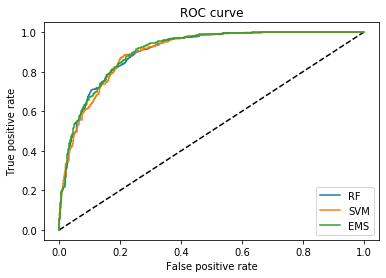

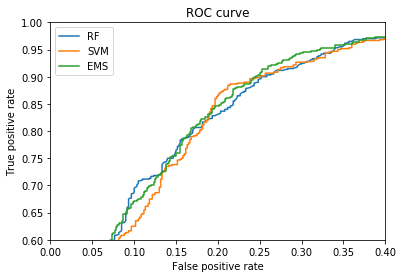

In [176]:
# Load models
if(dermo_challenge):
  clf_svm = load(path_general_feat+'SVM_W2_200.joblib') 
  clf_rf = load(path_general_feat+'RF_W2_200.joblib') 
  selected_rf=np.load(path_general_feat+ 'W2_f_classif_200.npy')
  selected_svm=np.load(path_general_feat+ 'W2_f_classif_200.npy')
else:
  clf_rf = load(path_general_feat+'RF_700.joblib') 
  clf_svm = load(path_general_feat+'SVM_700.joblib') 
  selected_rf=np.load(path_general_feat+ 'f_classif_700.npy')
  selected_svm=np.load(path_general_feat+ 'f_classif_700.npy')
# RF
s_X_val_rf=match_feat(X_val,selected_rf,names)
y_score_rf=clf_rf.predict_proba(s_X_val_rf)[:, 1]
fpr_rf_rf, tpr_rf_rf, _ = metrics.roc_curve(y_val, y_score_rf)
print("AUC  for RF ",metrics.roc_auc_score(y_val, y_score_rf))
# SVM
s_X_val_svm=match_feat(X_val,selected_svm,names)
print(s_X_val_svm.shape)
y_score_svm=clf_svm.predict_proba(s_X_val_svm)[:, 1]
fpr_rf_svm, tpr_rf_svm, _ = metrics.roc_curve(y_val, y_score_svm)
print("AUC  for SVM ",metrics.roc_auc_score(y_val, y_score_svm))
# Ensemble
if(dermo_challenge):
  y_score_ems=np.mean((y_score_svm,y_score_rf),axis=0)
else:
  y_score_ems=np.mean((y_score_svm,y_score_svm,y_score_rf),axis=0)

fpr_rf_ems, tpr_rf_ems, _ = metrics.roc_curve(y_val, y_score_ems)
print("AUC  for Ensemble ",metrics.roc_auc_score(y_val, y_score_ems))

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_val, y_score_ems>0.6)))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_rf, tpr_rf_rf, label='RF')
plt.plot(fpr_rf_svm, tpr_rf_svm, label='SVM')
plt.plot(fpr_rf_ems, tpr_rf_ems, label='EMS')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


plt.figure(2)
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_rf, tpr_rf_rf, label='RF')
plt.plot(fpr_rf_svm, tpr_rf_svm, label='SVM')
plt.plot(fpr_rf_ems, tpr_rf_ems, label='EMS')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Selection optimal operation point

In [177]:
from sklearn.metrics import confusion_matrix
if(dermo_challenge):
  prediction_threshold=0.6
else:
  prediction_threshold=0.4
print("Mean of scores is: ",np.mean( y_score_ems))
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_val, y_score_ems>prediction_threshold)))
print("Mean of predictions with 0.5 is (default) is: ",np.mean( y_score_ems>0.5))
print("Mean of predictions with ",prediction_threshold," is: ",np.mean( y_score_ems>prediction_threshold))
confusion_matrix(y_val, y_score_ems>prediction_threshold)

Mean of scores is:  0.5812547787325348
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81       600
         1.0       0.78      0.91      0.84       600

    accuracy                           0.83      1200
   macro avg       0.84      0.83      0.83      1200
weighted avg       0.84      0.83      0.83      1200


Mean of predictions with 0.5 is (default) is:  0.6258333333333334
Mean of predictions with  0.6  is:  0.57

array([[450, 150],
       [ 57, 543]])